# Section A: Training a Hidden Markov Model (20 Marks)

In this part of the assignment you have to train a Hidden Markov Model (HMM) for part-of-speech (POS)
tagging. Look at the solutions from Lab 3, Exercise 3 and Exercise 4 as a reminder for what you have to
compute.

You will need to create and train two models—an Emission Model and a Transition Model as described in
lectures.

Use labelled sentences from the ‘news’ part of the Brown corpus. These are annotated with parts of speech,
which you will convert into the Universal POS tagset (NLTK uses the smaller version of this set defined by
Petrov et al.6). Having a smaller number of labels (states) will make Viterbi decoding faster.
Use the last 500 sentences from the corpus as the test set and the rest for training. This split corresponds
roughly to a 90/10% division. Do not shuffle the data before splitting.

Failure to follow these instructions exactly will render most of your answers incorrect.

In [6]:
import inspect, sys, hashlib

# Hack around a warning message deep inside scikit learn, loaded by nltk :-(
#  Modelled on https://stackoverflow.com/a/25067818
import warnings
with warnings.catch_warnings(record=True) as w:
    save_filters=warnings.filters
    warnings.resetwarnings()
    warnings.simplefilter('ignore')
    import nltk
    warnings.filters=save_filters
try:
    nltk
except NameError:
    # didn't load, produce the warning
    import nltk

from nltk.corpus import brown
from nltk.tag import map_tag, tagset_mapping

################## MY IMPORTS
# Modules for computing Frequency Distributions and Probability Distributions
from nltk.probability import FreqDist, LidstoneProbDist, ConditionalProbDist

# Module for efficient iterating and looping
import itertools
##################

if map_tag('brown', 'universal', 'NR-TL') != 'NOUN':
    # Out-of-date tagset, we add a few that we need
    tm=tagset_mapping('en-brown','universal')
    tm['NR-TL']=tm['NR-TL-HL']='NOUN'

### Question 1 (10 Marks)

Estimate the Emission model: Fill in the emission_model method of the HMM class. Use a ConditionalProbDist
with a LidstoneProbDist estimator.

Review the help text for the ConditionalProbDist class. Note that the probdist_factory argument to its
__init__ method can be a function that takes a frequency distribution and returns a smoothed probability
distribution based on it, a.k.a. an estimator.

Review the help text for the LidstoneProbDist class and look particularly at the arguments to the __init__
method. You should implement a function to pass to ConditionalProbDist which creates and returns a
LidstoneProbDist based on the input frequency distribution, using +0.01 for smoothing and adding an extra
bin.

Convert all the observations (words) to lowercase.
Store the result in the variable self.emission_PD. Save the states (POS tags) that were seen in training in
the variable self.states. Both these variables will be used by the Viterbi algorithm in Section B.
Define an access function elprob for the emission model by filling in the function template provided.

### Question 2 (10 Marks)
Estimate the Transition model. Fill in the transition_model method of the HMM class. Use a ConditionalProbDist
with a LidstoneProbDist estimator using the same approach as in Question 1.

When using the training data for this step, add a start token (<s\>,<s\>) and an end token (</s\>,</s\>) to
each sentence, so that the resulting matrix has useful transition probabilities for transitions from <s\> to the real POS tags and from the real POS tags to </s\>. For example, for this sentence from the training data:

[( ’ Ask ’, ’ VERB ’) , ( ’ jail ’, ’NOUN ’) , (’ deputies ’, ’NOUN ’)]
you would use this as part of creating the transition model:

[( <s \> ,<s \>) ,( ’ Ask ’, ’ VERB ’) , ( ’ jail ’, ’NOUN ’) , (’ deputies ’, ’NOUN ’) ,
( </s \> , </s \>)]

Store the model in the variable self.transition_PD. This variable will be used by the Viterbi algorithm in
Section B.

Define an access function tlprob for the transition model by filling in the function template provided.

# Section B: Implementing The Viterbi Algorithm (55 Marks)

In this part of the assignment you have to implement the Viterbi algorithm. The pseudo-code of the algorithm
can be found in the Jurafsky & Martin 3rd edition book in Appendix A7 Figure A.9 in section A.4: use it as a
guide for your implementation.

However you will need to add to J&M’s algorithm code to make use of the transition probabilities to </s>
which are also now in the a matrix.

In the pseudo-code the b probabilities correspond to the emission model implemented in part A, question 1
and the a probabilities correspond to the transition model implemented in part A, question 2. You should use
costs (negative log probabilities). Therefore instead of multiplication of probabilities (as in the pseudo-code)
you will do addition of costs, and instead of max and argmax you will use min and argmin.

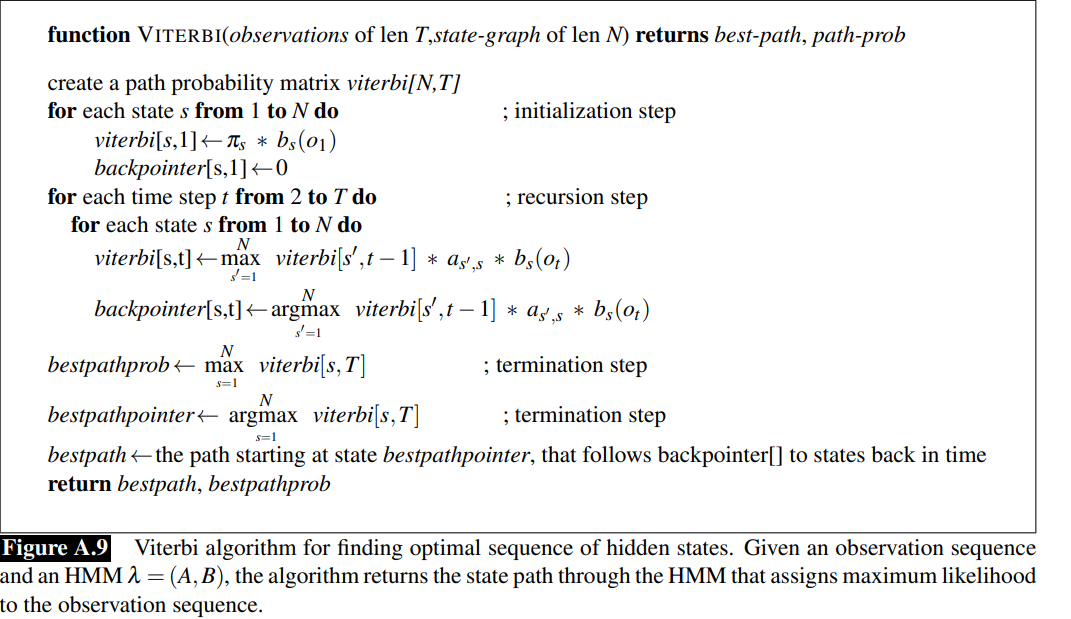

### Question 3 (20 Marks)
Implement the initialization step of the algorithm by filling in the initialise method. The argument
observation is the first word of the sentence to be tagged (o1 in the pseudo-code). Describe the data structures
with comments. 5 Marks

Note that per the instructions for Question 2 above, you will not need a separate π tabulation for the initialisation
step, because we’ve included start state probabilities in the a matrix as transitions from <s\> and you can use
that.

The algorithm uses two data structures that have to be initialized for each sentence that is being tagged: the
viterbi data structure (10 Marks) and the backpointer data structure (5 Marks). Use costs when initializing
the viterbi data structure.

Fill in the access functions get_viterbi_value and get_backpointer_value so that your Viterbi implementation can be queried without the caller needing to know how you implemented your data structures.
Then, fill in the model construction and training parts of the test code in the answers function and check the
results for plausibility.

In [ ]:
class HMM:
    def __init__(self, train_data, test_data):
        """
        Initialise a new instance of the HMM.

        :param train_data: The training dataset, a list of sentences with tags
        :type train_data: list(list(tuple(str,str)))
        :param test_data: the test/evaluation dataset, a list of sentence with tags
        :type test_data: list(list(tuple(str,str)))
        """
        self.train_data = train_data
        self.test_data = test_data

        # Emission and transition probability distributions
        self.emission_PD = None
        self.transition_PD = None
        self.states = []

        self.viterbi = []
        self.backpointer = []

    # Compute emission model using ConditionalProbDist with a LidstoneProbDist estimator.
    #   To achieve the latter, pass a function
    #    as the probdist_factory argument to ConditionalProbDist.
    #   This function should take 3 arguments
    #    and return a LidstoneProbDist initialised with +0.01 as gamma and an extra bin.
    #   See the documentation/help for ConditionalProbDist to see what arguments the
    #    probdist_factory function is called with.
    def emission_model(self, train_data):
        """
        Compute an emission model using a ConditionalProbDist.

        :param train_data: The training dataset, a list of sentences with tags
        :type train_data: list(list(tuple(str,str)))
        :return: The emission probability distribution and a list of the states
        :rtype: Tuple[ConditionalProbDist, list(str)]
        """
        raise NotImplementedError('HMM.emission_model')
        # TODO prepare data

        # Don't forget to lowercase the observation otherwise it mismatches the test data
        # Do NOT add <s> or </s> to the input sentences
        data = [(tag, word.lower()) for (word, tag) in train_data]

        # TODO compute the emission model
        emission_FD = FreqDist(data)
        lidstone_est = lambda fdist, gamma, bins: nltk.probability.LaplaceProbDist(fdist, 0.01, bins+1)
        self.emission_PD = ConditionalProbDist(cfdist=emission_FD, probdist_factory=est)
        self.states = list(set([tag for (tag, _) in data]))

        return self.emission_PD, self.states

    # Access function for testing the emission model
    # For example model.elprob('VERB','is') might be -1.4
    def elprob(self,state,word):
        """
        The log of the estimated probability of emitting a word from a state

        :param state: the state name
        :type state: str
        :param word: the word
        :type word: str
        :return: log base 2 of the estimated emission probability
        :rtype: float
        """
        #raise NotImplementedError('HMM.elprob')
        return self.emission_PD[state].prob(word)

    # Compute transition model using ConditionalProbDist with a LidstonelprobDist estimator.
    # See comments for emission_model above for details on the estimator.
    def transition_model(self, train_data):
        """
        Compute an transition model using a ConditionalProbDist.

        :param train_data: The training dataset, a list of sentences with tags
        :type train_data: list(list(tuple(str,str)))
        :return: The transition probability distribution
        :rtype: ConditionalProbDist
        """
        #raise NotImplementedError('HMM.transition_model')
        
        # TODO: prepare the data
        # The data object should be an array of tuples of conditions and observations,
        # in our case the tuples will be of the form (tag_(i),tag_(i+1)).
        # DON'T FORGET TO ADD THE START SYMBOL </s> and the END SYMBOL </s>
        tags_of_sents = [[('<s>',sent[0][1])] + zip(sent[:-1][1], sent[1:][1]) + [(sent[-1][1],'</s>')] for sent in train_data]
        data = itertools.chain.from_iterable(tags_of_sents)
        
        # TODO compute the transition model
        transition_FD = FreqDist(data)
        lidstone_est = lambda fdist, gamma, bins: nltk.probability.LaplaceProbDist(fdist, 0.01, bins+1)
        self.transition_PD = ConditionalProbDist(cfdist=transition_FD, probdist_factory=est)

        return self.transition_PD

    # Access function for testing the transition model
    # For example model.tlprob('VERB','VERB') might be -2.4
    def tlprob(self,state1,state2):
        """
        The log of the estimated probability of a transition from one state to another

        :param state1: the first state name
        :type state1: str
        :param state2: the second state name
        :type state2: str
        :return: log base 2 of the estimated transition probability
        :rtype: float
        """
        #raise NotImplementedError('HMM.tlprob')
        return self.transition_PD[state1].prob(state2)

    # Train the HMM
    def train(self):
        """
        Trains the HMM from the training data
        """
        self.emission_model(self.train_data)
        self.transition_model(self.train_data)

    # Part B: Implementing the Viterbi algorithm.

    # Initialise data structures for tagging a new sentence.
    # Describe the data structures with comments.
    # Use the models stored in the variables: self.emission_PD and self.transition_PD
    # Input: first word in the sentence to tag
    def initialise(self, observation):
        """
        Initialise data structures for tagging a new sentence.

        :param observation: the first word in the sentence to tag
        :type observation: str
        """
        #raise NotImplementedError('HMM.initialise')
        # Initialise step 0 of viterbi, including
        #  transition from <s> to observation
        # use costs (-log-base-2 probabilities)
        # fixme; DONE?
        
        # The viterbi data structure is an ARRAY OF DICTIONARIES [T observations/steps, N states]
        # The backpointer data structure is an ARRAY OF DICTIONARIES [T observations/steps, N states]
        # We initialise both as empty arrays. We will then append the dictionaries iteratively
        self.viterbi = []
        self.backpointer = []
        
        # We create a dictionary viterbi_step corresponding to step 0 of the viterbi algorithm
        # The keys are STATES and the values are COSTS at the current step (e.g. at step 0 'NOUN': 2.46)
        viterbi_step = {}
        
        # Calculate the costs of the first observation over all possible states; Add step 0 to the viterbi matrix 
        viterbi_step = {state: (-elprob(state, observation)-tlprob('<s>',state)) for state in self.states}
        self.viterbi.append(viterbi_step)
        
        # Initialise step 0 of backpointer; Append the dictionary corresponding to step 0 of the viterbi algorithm
        # The keys are STATES and the value is the 'parent', meaning the state/tag of the previous observation
        self.backpointer.append({state: '<s>' for state in self.states})

    # Tag a new sentence using the trained model and already initialised data structures.
    # Use the models stored in the variables: self.emission_PD and self.transition_PD.
    # Update the self.viterbi and self.backpointer datastructures.
    # Describe your implementation with comments.
    def tag(self, observations):
        """
        Tag a new sentence using the trained model and already initialised data structures.

        :param observations: List of words (a sentence) to be tagged
        :type observations: list(str)
        :return: List of tags corresponding to each word of the input
        """
        #raise NotImplementedError('HMM.tag')
        tags = []

        for obs_t in observations[1:]:
            # Initialise a dictionary viterbi_step which will contain the VITERBI COSTS at step t
            # The keys are STATES and the values are COSTS at the current step (e.g. at step t 'NOUN': 2.46)
            viterbi_step = {}
            
            # Initialise a dictionary backpointer_step which will contain the BACKPOINTERS at step t
            # The keys are STATES and the value is the 'parent', meaning the state/tag of the previous observation
            backpointer_step = {}
            
            for s in self.states: # iterate over all possible states
                # Compute the best (minimum) viterbi cost and its respective (argmin) backpointer
                # and update the viterbi and backpointer data structures
                viterbi_step[s], backpointer_step[s] = self.get_best_viterbi_state(s, -1, obs_t)
            
            # Append the dictionaries of this observation to the global variables viterbi and backpointer
            self.viterbi.append(viterbi_step)
            self.backpointer.append(backpointer_step)
        
        # Add a termination step with cost based solely on cost of transition to </s> , end of sentence.
        min_cost = float("inf")
        argmin_backpointer = 0
        for s in self.states:
            s_cost = self.get_viterbi_value(s, -1) -tlprob(s, '</s>')
            if s_cost < min_cost:
                min_cost = s_cost
                argmin_backpointer = s
        
        self.viterbi.append({'</s>': min_cost})
        self.backpointer.append({'</s>': argmin_backpointer})
        
        # Reconstruct the tag sequence using the backpointer list.
        # Return the tag sequence corresponding to the best path as a list.
        # The order should match that of the words in the sentence.
        #TODO
        
        tags = ... # fixme

        return tags

    # Access function for testing the viterbi data structure
    # For example model.get_viterbi_value('VERB',2) might be 6.42 
    def get_viterbi_value(self, state, step):
        """
        Return the current value from self.viterbi for
        the state (tag) at a given step

        :param state: A tag name
        :type state: str
        :param step: The (0-origin) number of a step:  if negative,
          counting backwards from the end, i.e. -1 means the last step
        :type step: int
        :return: The value (a cost) for state as of step
        :rtype: float
        """
        #raise NotImplementedError('HMM.get_viterbi_value')
        return self.viterbi[step].get(state)

    # Access function for testing the backpointer data structure
    # For example model.get_backpointer_value('VERB',2) might be 'NOUN'
    def get_backpointer_value(self, state, step):
        """
        Return the current backpointer from self.backpointer for
        the state (tag) at a given step

        :param state: A tag name
        :type state: str
        :param step: The (0-origin) number of a step:  if negative,
          counting backwards from the end, i.e. -1 means the last step
        :type step: int
        :return: The state name to go back to at step-1
        :rtype: str
        """
        #raise NotImplementedError('HMM.get_backpointer_value')
        return self.backpointer[step].get(state)

    
    ################### HELPER METHODS ##########################
    def get_best_viterbi_state(self, state, step, obs)
        """
        Return the best (lowerst) viterbi cost and backpointer
        for the state (tag) at a given step. This is used in the
        VITERBI algorithm
        
        :param state: A tag name
        :type state: str
        :param step: The (0-origin) number of a step:  if negative,
          counting backwards from the end, i.e. -1 means the last step
        :type step: int
        :param obs: The observation (word) at the current step
        :type state: str
        :return: The best (lowest) viterbi cost for the current state & step
          and the corresponding backpointer
        :rtype: Tuple[float, str]
        """
        min_cost = float("inf")
        argmin_backpointer = 0
        for s in self.states:
            s_cost = self.get_viterbi_value(s, step-1) -elprob(state, obs) -tlprob(s, state)
            if s_cost < min_cost:
                min_cost = s_cost
                argmin_backpointer = s
        return min_cost, argmin_backpointer
    

In [ ]:
def answer_question4b():
    """
    Report a hand-chosen tagged sequence that is incorrect, correct it
    and discuss
    :rtype: list(tuple(str,str)), list(tuple(str,str)), str
    :return: your answer [max 280 chars]
    """
    raise NotImplementedError('answer_question4b')

    # One sentence, i.e. a list of word/tag pairs, in two versions
    #  1) As tagged by your HMM
    #  2) With wrong tags corrected by hand
    tagged_sequence = 'fixme'
    correct_sequence = 'fixme'
    # Why do you think the tagger tagged this example incorrectly?
    answer =  inspect.cleandoc("""\
    fill me in""")[0:280]

    return tagged_sequence, correct_sequence, answer

In [ ]:
def answer_question5():
    """
    Suppose you have a hand-crafted grammar that has 100% coverage on
        constructions but less than 100% lexical coverage.
        How could you use a POS tagger to ensure that the grammar
        produces a parse for any well-formed sentence,
        even when it doesn't recognise the words within that sentence?

    :rtype: str
    :return: your answer [max 500 chars]
    """
    raise NotImplementedError('answer_question5')

    return inspect.cleandoc("""\
    fill me in""")[0:500]


In [ ]:
def answer_question6():
    """
    Why else, besides the speedup already mentioned above, do you think we
    converted the original Brown Corpus tagset to the Universal tagset?
    What do you predict would happen if we hadn't done that?  Why?

    :rtype: str
    :return: your answer [max 500 chars]
    """
    raise NotImplementedError('answer_question6')

    return inspect.cleandoc("""\
    fill me in""")[0:500]

In [ ]:
# Useful for testing
def isclose(a, b, rel_tol=1e-09, abs_tol=0.0):
    # http://stackoverflow.com/a/33024979
    return abs(a - b) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)

def answers():
    global tagged_sentences_universal, test_data_universal, \
           train_data_universal, model, test_size, train_size, ttags, \
           correct, incorrect, accuracy, \
           good_tags, bad_tags, answer4b, answer5
    
    # Load the Brown corpus with the Universal tag set.
    tagged_sentences_universal = brown.tagged_sents(categories='news', tagset='universal')

    # Divide corpus into train and test data.
    test_size = 500
    train_size = len(tagged_sentences_universal) - test_size # fixme; DONE?

    test_data_universal = tagged_sentences_universal[-test_size:] # fixme; DONE?
    train_data_universal = tagged_sentences_universal[:train_size] # fixme; DONE?

    if hashlib.md5(''.join(map(lambda x:x[0],train_data_universal[0]+train_data_universal[-1]+test_data_universal[0]+test_data_universal[-1])).encode('utf-8')).hexdigest()!='164179b8e679e96b2d7ff7d360b75735':
        print('!!!test/train split (%s/%s) incorrect, most of your answers will be wrong hereafter!!!'%(len(train_data_universal),len(test_data_universal)),file=sys.stderr)

    # Create instance of HMM class and initialise the training and test sets.
    model = HMM(train_data_universal, test_data_universal)

    # Train the HMM.
    model.train()

    # Some preliminary sanity checks
    # Use these as a model for other checks
    e_sample=model.elprob('VERB','is')
    if not (type(e_sample)==float and e_sample<=0.0):
        print('elprob value (%s) must be a log probability'%e_sample,file=sys.stderr)

    t_sample=model.tlprob('VERB','VERB')
    if not (type(t_sample)==float and t_sample<=0.0):
           print('tlprob value (%s) must be a log probability'%t_sample,file=sys.stderr)

    if not (type(model.states)==list and \
            len(model.states)>0 and \
            type(model.states[0])==str):
        print('model.states value (%s) must be a non-empty list of strings'%model.states,file=sys.stderr)

    print('states: %s\n'%model.states)

    ######
    # Try the model, and test its accuracy [won't do anything useful
    #  until you've filled in the tag method
    ######
    s='the cat in the hat came back'.split()
    model.initialise(s[0])
    ttags = [] # fixme
    print("Tagged a trial sentence:\n  %s"%list(zip(s,ttags)))

    v_sample=model.get_viterbi_value('VERB',5)
    if not (type(v_sample)==float and 0.0<=v_sample):
           print('viterbi value (%s) must be a cost'%v_sample,file=sys.stderr)

    b_sample=model.get_backpointer_value('VERB',5)
    if not (type(b_sample)==str and b_sample in model.states):
           print('backpointer value (%s) must be a state name'%b_sample,file=sys.stderr)


    # check the model's accuracy (% correct) using the test set
    correct = 0
    incorrect = 0

    for sentence in test_data_universal:
        s = [word.lower() for (word, tag) in sentence]
        model.initialise(s[0])
        tags = model.tag(s)

        for ((word,gold),tag) in zip(sentence,tags):
            if tag == gold:
                pass # fix me
            else:
                pass # fix me

    accuracy = 0.0 # fix me
    print('Tagging accuracy for test set of %s sentences: %.4f'%(test_size,accuracy))

    # Print answers for 4b, 5 and 6
    bad_tags, good_tags, answer4b = answer_question4b()
    print('\nA tagged-by-your-model version of a sentence:')
    print(bad_tags)
    print('The tagged version of this sentence from the corpus:')
    print(good_tags)
    print('\nDiscussion of the difference:')
    print(answer4b[:280])
    answer5=answer_question5()
    print('\nFor Q5:')
    print(answer5[:500])
    answer6=answer_question6()
    print('\nFor Q6:')
    print(answer6[:500])

In [ ]:
if len(sys.argv)>1 and sys.argv[1] == '--answers':
        import adrive2_embed
        from autodrive_embed import run, carefulBind
        with open("userErrs.txt","w") as errlog:
            run(globals(),answers,adrive2_embed.a2answers,errlog)
    else:
        answers()